Import libraries

In [1]:
import seaborn as sn
import pandas as pd
import json, os
import numpy as np
import csv
import matplotlib.pyplot as plt
import random
from collections import OrderedDict
import time
import random

import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dense, GlobalMaxPool1D
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow.keras.backend as K

from transformers import AutoTokenizer, TFAutoModelForSequenceClassification #, BertModel, BertTokenizer, TFBertForSequenceClassification
from transformers import set_seed

from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score, \
roc_auc_score, confusion_matrix, classification_report
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split


C:\Users\iliaskaloup\AppData\Local\anaconda3\envs\tfenv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Specify a constant seeder for processes

In [2]:
seed = 123
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)
set_seed(seed)

Pre-trained tokenizer

In [3]:
model_variation = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_variation, do_lower_case=True) #Tokenizer
#bert-base-uncased #bert-base # roberta-base # distilbert-base-uncased #distilbert-base # microsoft/codebert-base-mlm
# 'albert-base-v2'

In [4]:
# Define New tokens for string and numerical i.e., strId$ and numId$
new_tokens = ["strId$", "numId$"]
for new_token in new_tokens:
    if new_token not in tokenizer.get_vocab().keys():
        tokenizer.add_tokens(new_token)

In [5]:
def recall_metric(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = (true_positives + K.epsilon()) / (possible_positives + K.epsilon())
        return recall

def precision_metric(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = (true_positives + K.epsilon()) / (predicted_positives + K.epsilon())
        return precision

def f1_metric(y_true, y_pred):

    prec = precision_metric(y_true, y_pred)
    rec = recall_metric(y_true, y_pred)
    f1 = 2*((prec*rec)/(prec+rec+K.epsilon()))
    return f1

def f2_metric(y_true, y_pred):

    prec = precision_metric(y_true, y_pred)
    rec = recall_metric(y_true, y_pred)
    f2 = 5*((prec*rec)/(4*prec+rec+K.epsilon()))
    return f2


In [6]:
def dropEmpty(tokens0):
    tokens = []
    for i in range(0, len(tokens0)):
        temp = tokens0[i]
        if temp != []:
            tokens.append(temp)
    return tokens

def listToString(s): 
    
    # initialize an empty string
    str1 = "" 
    
    # traverse in the string 
    count = 0
    for ele in s: 
        if count==0:
            str1 = str1 + ele
        else:
            str1 = str1 + ' ' + ele
        count = count + 1
        #str1 += ele  
    
    # return string  
    return str1

def prepareData(data):
        
    # lowercase
    lines = []
    labels = []
    headlines = []
    for i in range(0, len(data)):
        labels.append(int(data[i][1]))
        headlines.append(data[i][0])
        line = data[i][2:]
        lows = [w.lower() for w in line]
        lines.append(lows)
    
    texts = []
    for i in range(0, len(lines)):
        texts.append(listToString(lines[i]))
    
    return texts, labels, headlines 

Read dataset

In [7]:
root_path = os.path.join('..', '..')
with open(os.path.join(root_path, 'data', 'dataset.csv'), newline='', encoding='utf-8') as f:
    reader = csv.reader(f)
    data = list(reader)
data = dropEmpty(data)

In [8]:
# Shuffle dataset

In [9]:
random.shuffle(data)

In [10]:
texts, labels, headlines = prepareData(data)

Explore data

Elements in dataset: 4184
2 categories found:
0
1


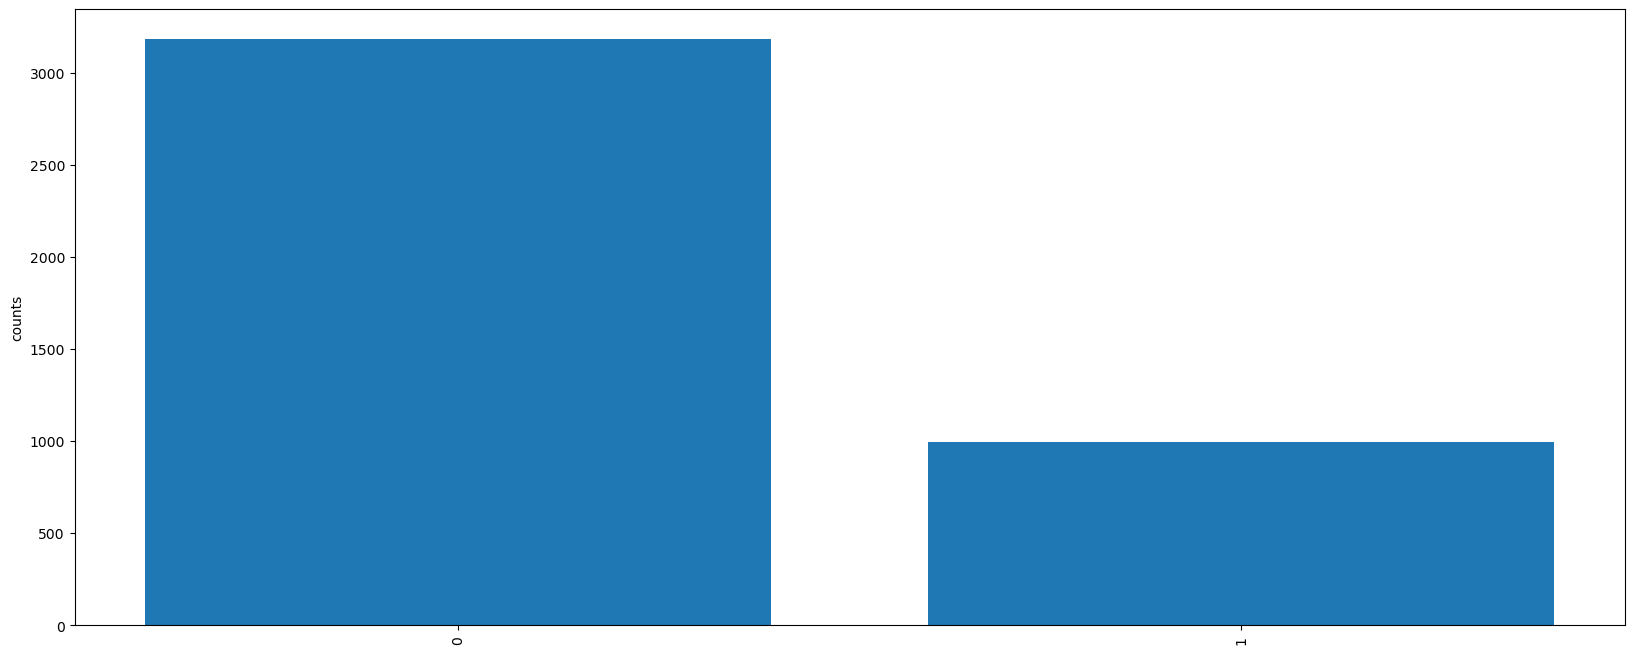

In [11]:
n_elements=len(headlines)
print('Elements in dataset:', n_elements)
categories=sorted(list(set(labels))) #set will return the unique different entries
n_categories=len(categories)
print("{} categories found:".format(n_categories))
for category in categories:
    print(category)
    
fig=plt.figure(figsize=(20,8))
lbl, counts = np.unique(labels,return_counts=True)
ticks = range(len(counts))
plt.bar(ticks,counts, align='center')
plt.xticks(ticks,lbl)
plt.xticks(rotation=90)
plt.ylabel('counts')
plt.show()

In [12]:
data = pd.DataFrame(({'Text': texts, 'Labels': labels}))

Split to train-val-test

In [13]:
val_ratio = 0.10

In [14]:
train_val_data, test_data = train_test_split(data, test_size=val_ratio, random_state=seed, stratify=data['Labels'])
train_data, val_data = train_test_split(train_val_data, test_size=val_ratio, random_state=seed, stratify=train_val_data['Labels'])
# print(len(data))
# print(len(train_val_data))
# print(len(test_data))
# print(len(train_data))
# print(len(val_data))
# print(len(val_data)+len(train_data)+len(test_data))
# print(len(val_data)+len(train_data))

Pre-trained model

In [15]:
model = TFAutoModelForSequenceClassification.from_pretrained(model_variation, num_labels=n_categories)

config = model.get_config()
print(config)

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'return_dict': True, 'output_hidden_states': False, 'output_attentions': False, 'torchscript': False, 'torch_dtype': None, 'use_bfloat16': False, 'tf_legacy_loss': False, 'pruned_heads': {}, 'tie_word_embeddings': True, 'chunk_size_feed_forward': 0, 'is_encoder_decoder': False, 'is_decoder': False, 'cross_attention_hidden_size': None, 'add_cross_attention': False, 'tie_encoder_decoder': False, 'max_length': 20, 'min_length': 0, 'do_sample': False, 'early_stopping': False, 'num_beams': 1, 'num_beam_groups': 1, 'diversity_penalty': 0.0, 'temperature': 1.0, 'top_k': 50, 'top_p': 1.0, 'typical_p': 1.0, 'repetition_penalty': 1.0, 'length_penalty': 1.0, 'no_repeat_ngram_size': 0, 'encoder_no_repeat_ngram_size': 0, 'bad_words_ids': None, 'num_return_sequences': 1, 'output_scores': False, 'return_dict_in_generate': False, 'forced_bos_token_id': None, 'forced_eos_token_id': None, 'remove_invalid_values': False, 'exponential_decay_length_penalty': None, 'suppress_tokens': None, 'begin_suppress_

Resize model embedding to match new tokenizer

In [16]:
model.resize_token_embeddings(len(tokenizer))

Compute maximum length

In [17]:
def getMaxLen(X):

    # Code for identifying max length of the data samples after tokenization using transformer tokenizer
    
    max_length = 0
    # Iterate over each sample in your dataset
    for i, input_ids in enumerate(X['input_ids']):
        # Calculate the length of the tokenized sequence for the current sample
        length = tf.math.reduce_sum(tf.cast(input_ids != 1, tf.int32)).numpy()
        # Update max_length and max_row if the current length is greater
        if length > max_length:
            max_length = length
            max_row = i

    print("Max length of tokenized data:", max_length)
    print("Row with max length:", max_row)

    #X['input_ids'] = np.delete(X['input_ids'], max_row, axis=0)
    
    return max_length

In [18]:
X = tokenizer(
        text=train_data['Text'].tolist(),
        add_special_tokens=True,
        max_length=512,
        truncation=True,
        padding=True,
        return_tensors='tf',
        return_token_type_ids=False,
        return_attention_mask=True,
        verbose=True
    )

max_len = getMaxLen(X)

Max length of tokenized data: 512
Row with max length: 0


Tokenization

In [19]:
X_train = tokenizer(
    text=train_data['Text'].tolist(),
    add_special_tokens=True,
    max_length=max_len,
    truncation=True,
    padding=True,
    return_tensors='tf',
    return_token_type_ids=False,
    return_attention_mask=True,
    verbose=True
)

X_val = tokenizer(
    text=val_data['Text'].tolist(),
    add_special_tokens=True,
    max_length=max_len,
    truncation=True,
    padding=True,
    return_tensors='tf',
    return_token_type_ids=False,
    return_attention_mask=True,
    verbose=True
)

X_test = tokenizer(
    text=test_data['Text'].tolist(),
    add_special_tokens=True,
    max_length=max_len,
    truncation=True,
    padding=True,
    return_tensors='tf',
    return_token_type_ids=False,
    return_attention_mask=True,
    verbose=True
)

Hyper-parameters

In [20]:
n_epochs = 6
batch_size = 6
lr = 5e-05
patience = 5

In [21]:
optimizer = Adam(
    learning_rate=lr, # HF recommendation
    epsilon=1e-08,
    clipnorm=1.0
)

loss = CategoricalCrossentropy(from_logits=True)

Build Model

In [22]:
model.compile(
    optimizer=optimizer,
    loss=loss
)

Train model

In [23]:
print("Training...")
milli_sec1 = int(round(time.time() * 1000))

early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=patience)
model_checkpoint = ModelCheckpoint('./checkpoints/best_weights', monitor='val_loss', mode='min', save_best_only=True)

history = model.fit(
    x = {'input_ids':X_train['input_ids'], 'attention_mask':X_train['attention_mask']},
    y = to_categorical(train_data['Labels']),
    validation_data = ({'input_ids':X_val['input_ids'], 'attention_mask':X_val['attention_mask']},
                        to_categorical(val_data['Labels'])),
    epochs=n_epochs,
    batch_size=batch_size,
    callbacks=[early_stopping, model_checkpoint]
)

milli_sec2 = int(round(time.time() * 1000))
print("Training is completed after", milli_sec2-milli_sec1)

Training...
Epoch 1/6
565/565 [==============================] - ETA: 0s - loss: 0.4646

INFO:tensorflow:Assets written to: ./checkpoints\best_weights\assets


INFO:tensorflow:Assets written to: ./checkpoints\best_weights\assets


565/565 [==============================] - 155s 238ms/step - loss: 0.4646 - val_loss: 0.3987
Epoch 2/6
565/565 [==============================] - 105s 186ms/step - loss: 0.3689 - val_loss: 0.4410
Epoch 3/6
565/565 [==============================] - ETA: 0s - loss: 0.4070

INFO:tensorflow:Assets written to: ./checkpoints\best_weights\assets


INFO:tensorflow:Assets written to: ./checkpoints\best_weights\assets


565/565 [==============================] - 133s 235ms/step - loss: 0.4070 - val_loss: 0.3948
Epoch 4/6
565/565 [==============================] - 106s 187ms/step - loss: 0.3417 - val_loss: 0.3961
Epoch 5/6
565/565 [==============================] - 106s 187ms/step - loss: 0.3219 - val_loss: 0.4425
Epoch 6/6
565/565 [==============================] - 106s 187ms/step - loss: 0.3249 - val_loss: 0.4471
Training is completed after 710125


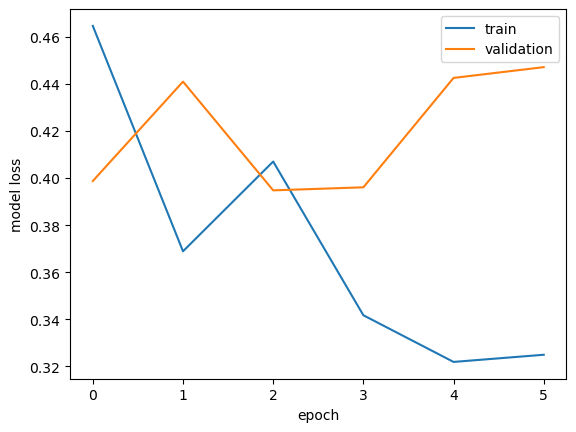

In [24]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('model loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='best')
#plt.savefig('train_history.png')
plt.show()


Load best model from checkpoint during training with early stopping

In [25]:
model.load_weights('./checkpoints/best_weights')

Classification report on validation data

In [26]:
print(classification_report(val_data['Labels'], np.argmax(model.predict({'input_ids': X_val['input_ids'], 'attention_mask': X_val['attention_mask']}).logits, axis=1)))

12/12 [==============================] - 6s 270ms/step
              precision    recall  f1-score   support

           0       0.88      0.97      0.92       287
           1       0.87      0.58      0.69        90

    accuracy                           0.88       377
   macro avg       0.87      0.77      0.81       377
weighted avg       0.88      0.88      0.87       377



Make predictions on the testing set and compute evaluation metrics

In [27]:
predicted = model.predict({'input_ids': X_test['input_ids'], 'attention_mask': X_test['attention_mask']}).logits
y_predicted = np.argmax(predicted, axis=1)

targets = test_data['Labels']
print(classification_report(targets, y_predicted))

14/14 [==============================] - 4s 255ms/step
              precision    recall  f1-score   support

           0       0.88      0.98      0.93       319
           1       0.89      0.57      0.70       100

    accuracy                           0.88       419
   macro avg       0.88      0.77      0.81       419
weighted avg       0.88      0.88      0.87       419



TP= 57
TN= 312
FP= 7
FN= 43
Accuracy:88.07%
Precision:89.06%
Recall:57.00%
Roc_Auc score:77.40%
F1 score:69.51%
F2 score:61.42%


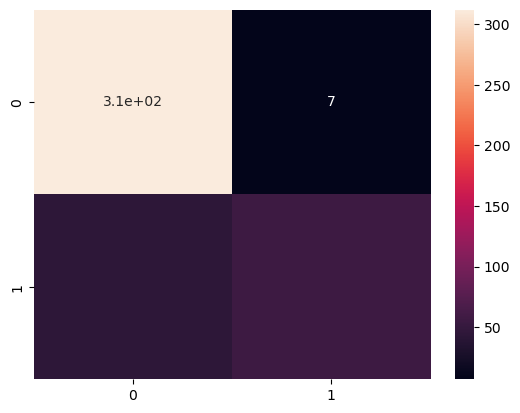

In [28]:
accuracy=accuracy_score(targets, y_predicted)
precision=precision_score(targets, y_predicted)
recall=recall_score(targets, y_predicted)
roc_auc=roc_auc_score(targets, y_predicted)
f1=f1_score(targets, y_predicted)
f2 = (5*precision*recall) / (4*precision+recall)

conf_matrix = confusion_matrix(targets, y_predicted)
sn.heatmap(conf_matrix, annot=True)

tn, fp, fn, tp = conf_matrix.ravel()
acc = ((tp+tn)/(tp+tn+fp+fn))
print("TP=",tp)
print("TN=",tn)
print("FP=",fp)
print("FN=",fn)

print("Accuracy:%.2f%%"%(accuracy*100))
print("Precision:%.2f%%"%(precision*100))
print("Recall:%.2f%%"%(recall*100))
print("Roc_Auc score:%.2f%%"%(roc_auc*100))
print("F1 score:%.2f%%"%(f1*100))
print("F2 score:%.2f%%"%(f2*100))